In [63]:
# Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F  # Make sure this import is here


In [64]:
# This script includes lat, lon and compass orientation
import os
import json
import torch
from torch.utils.data import Dataset

# Define the custom dataset for your specific data structure
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the expensive GPS data as the target output
            if "expensive_latitude" in image_info and "expensive_longitude" in image_info and "expensive_heading" in image_info:
                expensive_latitude = float(image_info['expensive_latitude'])
                expensive_longitude = float(image_info['expensive_longitude'])
                expensive_heading = float(image_info['expensive_heading'])
                # expensive_heading = float(0.0)  # Set expensive_heading to 0 for all images                
                
                # The target is the accurate GPS data
                geolocation = [expensive_latitude, expensive_longitude, expensive_heading]
                
                # Initialize the input vector with zeros
                input_vector = [0] * input_size

                # Find annotations corresponding to the image
                annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
                for ann in annotations:
                    class_id = ann['category_id']
                    bbox = ann['bbox']
                    instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                    if instance_index < max_instances_per_class:
                        start_index = (class_id * max_instances_per_class + instance_index) * 4
                        input_vector[start_index:start_index + 4] = bbox

                bounding_boxes.append(input_vector)
                geolocations.append(geolocation)
                image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path


In [70]:
# class FFNN(nn.Module):
#     def __init__(self):
#         super(FFNN, self).__init__()
#         self.fc1 = nn.Linear(72, 48)  # Single hidden layer with 256 neurons
#         self.bn1 = nn.BatchNorm1d(48)  # Added batch normalization
#         self.fc2 = nn.Linear(48, 3)    # Output layer (latitude and longitude)
#         self.dropout = nn.Dropout(p=0.3)  # Added dropout

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
#         x = self.dropout(x)  # Apply dropout before the final output layer
#         x = self.fc2(x)  # Output layer
#         return x
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(72, 64)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(60, 64)  # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 3)    # Output layer (latitude, longitude, and orientation)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))  # First hidden layer with activation
        # x = F.leaky_relu(self.fc2(x))  # Second hidden layer with activation
        x = self.fc3(x)  # Output layer (latitude, longitude, and orientation)
        return x


In [66]:
# Load the COCO JSON data
coco_file_path = 'Test_4/Filtered_Lat_Lon_2BBox_Each_Class_Annotation.json'  
images_dir = 'Test_4/captured_images_test4' 

In [67]:
# Create the dataset
dataset = COCOGeolocationDataset(coco_file_path, images_dir)

print(f"Example bounding box: {dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)


Example bounding box: torch.Size([72])


In [74]:
model = FFNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for inputs, targets, _ in train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    # scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    
# Save the trained model
model_save_path = "lan_lon_model.pt"
torch.save(model.state_dict(), model_save_path)
print("Training completed!")

Epoch [1/100], Loss: 6470.04248047
Epoch [2/100], Loss: 2675.59692383
Epoch [3/100], Loss: 2822.88378906
Epoch [4/100], Loss: 2825.63696289
Epoch [5/100], Loss: 2557.87597656
Epoch [6/100], Loss: 1498.41259766
Epoch [7/100], Loss: 4360.20166016
Epoch [8/100], Loss: 7490.43505859
Epoch [9/100], Loss: 4889.58789062
Epoch [10/100], Loss: 2605.96411133
Epoch [11/100], Loss: 3064.66235352
Epoch [12/100], Loss: 2367.94018555
Epoch [13/100], Loss: 1821.10864258
Epoch [14/100], Loss: 4846.27734375
Epoch [15/100], Loss: 4094.11499023
Epoch [16/100], Loss: 3689.26098633
Epoch [17/100], Loss: 1567.45080566
Epoch [18/100], Loss: 4019.58496094
Epoch [19/100], Loss: 4879.09277344
Epoch [20/100], Loss: 1758.28515625
Epoch [21/100], Loss: 2657.40722656
Epoch [22/100], Loss: 2655.12377930
Epoch [23/100], Loss: 2715.28417969
Epoch [24/100], Loss: 5621.65234375
Epoch [25/100], Loss: 1206.17272949
Epoch [26/100], Loss: 1105.88757324
Epoch [27/100], Loss: 4912.63378906
Epoch [28/100], Loss: 2081.77148438
E

Mean Squared Error on Test Set: 2574.2698
Root Mean Squared Error (RMSE) on Test Set: 50.7373
Actual: (35.77, -78.67, 186.81)
Predicted: (33.29, -71.81, 193.18)


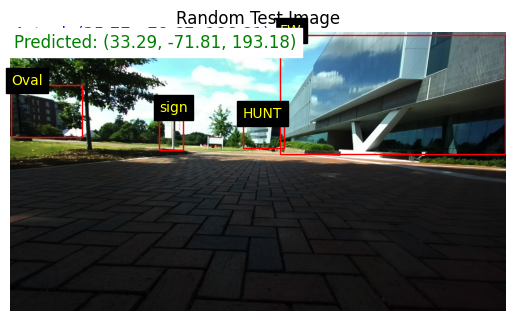

Actual: (35.77, -78.68, 25.28)
Predicted: (32.75, -74.33, 47.46)


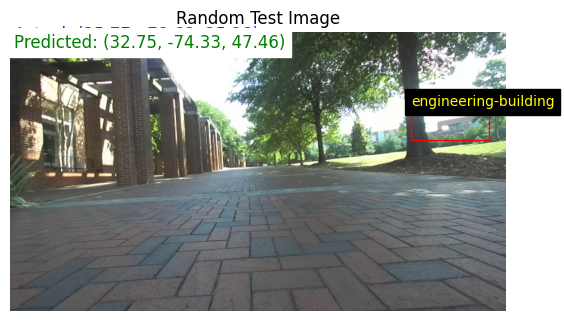

Actual: (35.77, -78.67, 124.75)
Predicted: (37.50, -79.60, 115.00)


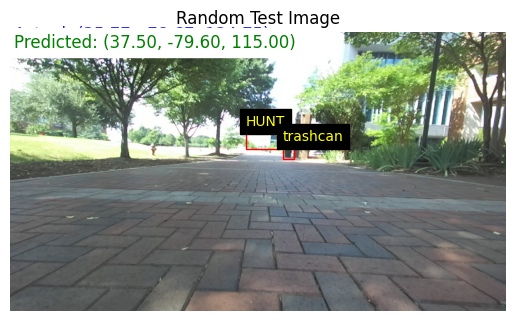

Actual: (35.77, -78.68, 214.37)
Predicted: (35.43, -76.75, 140.32)


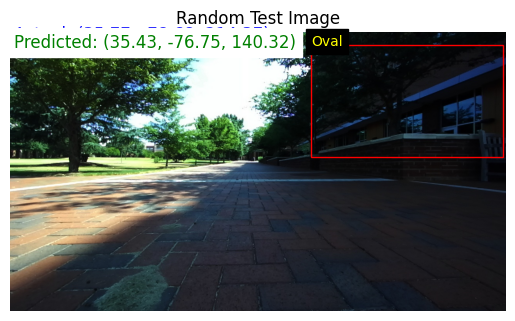

Actual: (35.77, -78.67, 300.24)
Predicted: (39.20, -87.69, 317.67)


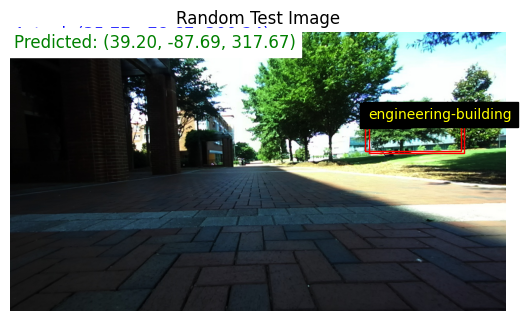

In [72]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_targets = []
image_paths = []

with torch.no_grad():
    for inputs, targets, paths in test_dataloader:
        outputs = model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)

all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set: {mse:.4f}')

import math
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}')

# Function to visualize random test images with bounding boxes and geolocation labels
def visualize_random_predictions(test_dataset, all_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_geolocation = all_predictions[i].cpu().numpy()
        
        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display geolocations with clear labels
        plt.text(10, 20, f"Actual: ({geolocation[0]:.2f}, {geolocation[1]:.2f}, {geolocation[2]:.2f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted: ({predicted_geolocation[0]:.2f}, {predicted_geolocation[1]:.2f}, {predicted_geolocation[2]:.2f})", color='green', fontsize=12, backgroundcolor='white')
        print(f"Actual: ({geolocation[0]:.2f}, {geolocation[1]:.2f}, {geolocation[2]:.2f})")
        print(f"Predicted: ({predicted_geolocation[0]:.2f}, {predicted_geolocation[1]:.2f}, {predicted_geolocation[2]:.2f})")
        plt.title('Random Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the test set
visualize_random_predictions(test_dataset, all_predictions, num_images=5)


In [58]:
## This code is for only lat and lon not compass orientation
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F  # Make sure this import is here

# Define the custom dataset for your specific data structure
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the expensive GPS data as the target output
            expensive_latitude = float(image_info['expensive_latitude'])
            expensive_longitude = float(image_info['expensive_longitude'])
            # Ensure that only latitude and longitude are included
            geolocation = [expensive_latitude, expensive_longitude]
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)  # Only latitude and longitude are appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)  # This should now be of shape [2]
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path

# Create the dataset
dataset = COCOGeolocationDataset(coco_file_path, images_dir)

print(f"Example bounding box: {dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(72, 40)  # Single hidden layer with 256 neurons
        self.bn1 = nn.BatchNorm1d(40)  # Added batch normalization
        self.fc2 = nn.Linear(40, 2)    # Output layer (latitude and longitude)
        self.dropout = nn.Dropout(p=0.3)  # Added dropout

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
        x = self.dropout(x)  # Apply dropout before the final output layer
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model, loss function, and optimizer
model = FFNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    for inputs, targets, _ in train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    
# Save the trained model
model_save_path = "lan_lon_model.pt"
torch.save(model.state_dict(), model_save_path)
print("Training completed!")


Example bounding box: torch.Size([72])
Epoch [1/300], Loss: 91.91172791
Epoch [2/300], Loss: 72.51845551
Epoch [3/300], Loss: 12.09430122
Epoch [4/300], Loss: 57.52308655
Epoch [5/300], Loss: 49.73490906
Epoch [6/300], Loss: 14.38006973
Epoch [7/300], Loss: 25.13789177
Epoch [8/300], Loss: 19.50956726
Epoch [9/300], Loss: 18.26328850
Epoch [10/300], Loss: 29.99365616
Epoch [11/300], Loss: 6.85719967
Epoch [12/300], Loss: 4.43347263
Epoch [13/300], Loss: 4.33314562
Epoch [14/300], Loss: 9.31496811
Epoch [15/300], Loss: 4.02610636
Epoch [16/300], Loss: 6.25302410
Epoch [17/300], Loss: 3.57446289
Epoch [18/300], Loss: 2.91694593
Epoch [19/300], Loss: 3.90113831
Epoch [20/300], Loss: 1.14547706
Epoch [21/300], Loss: 3.07774520
Epoch [22/300], Loss: 1.04213452
Epoch [23/300], Loss: 1.74674702
Epoch [24/300], Loss: 1.20457983
Epoch [25/300], Loss: 0.66039133
Epoch [26/300], Loss: 0.40856442
Epoch [27/300], Loss: 0.16275260
Epoch [28/300], Loss: 0.06375592
Epoch [29/300], Loss: 0.07246049
Epo

Mean Squared Error on Test Set: 0.00000043
Root Mean Squared Error (RMSE) on Test Set: 0.00065444
Actual: (35.77103043, -78.67509460)
Predicted: (35.77072525, -78.67491150)


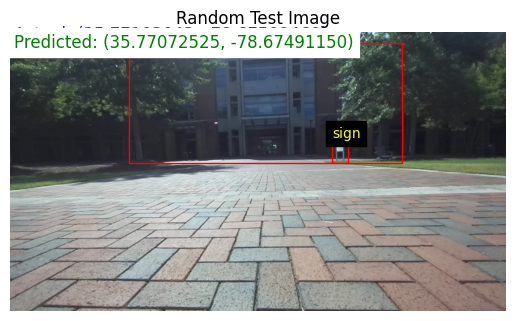

Actual: (35.77006531, -78.67483521)
Predicted: (35.77080154, -78.67488861)


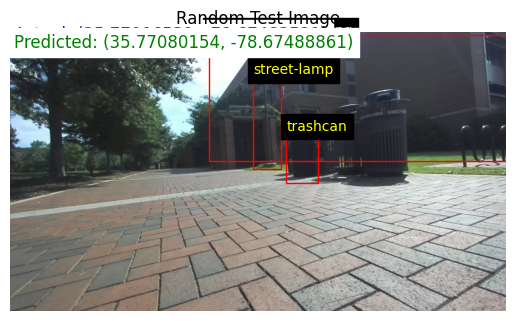

Actual: (35.77171326, -78.67421722)
Predicted: (35.77095795, -78.67474365)


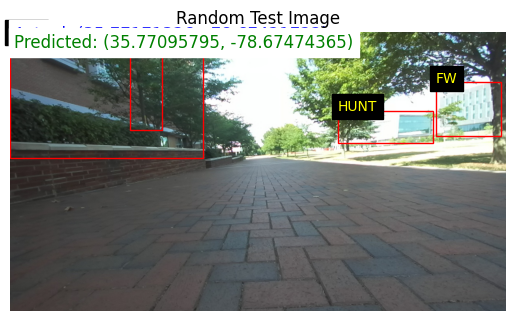

Actual: (35.77087784, -78.67520142)
Predicted: (35.77071381, -78.67496490)


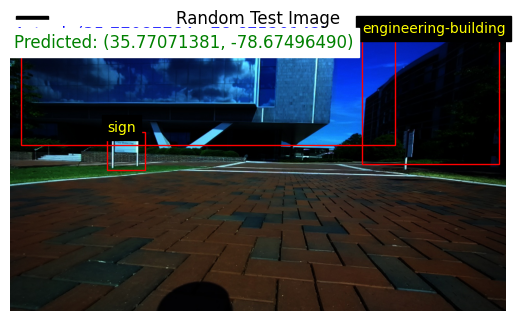

Actual: (35.77064514, -78.67435455)
Predicted: (35.77069855, -78.67494202)


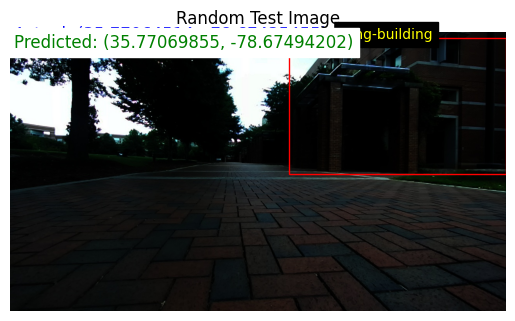

Actual: (35.77069473, -78.67534637)
Predicted: (35.77076340, -78.67488098)


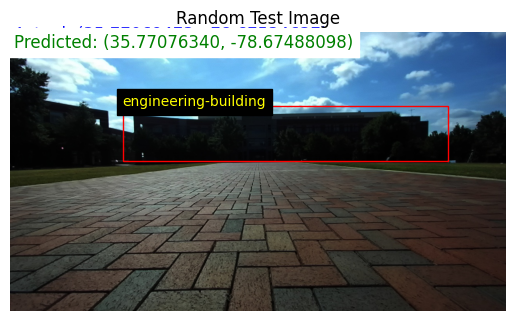

Actual: (35.77028275, -78.67465210)
Predicted: (35.77045441, -78.67520905)


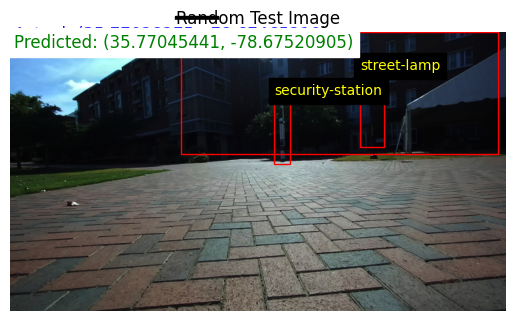

Actual: (35.77108002, -78.67505646)
Predicted: (35.77065659, -78.67495728)


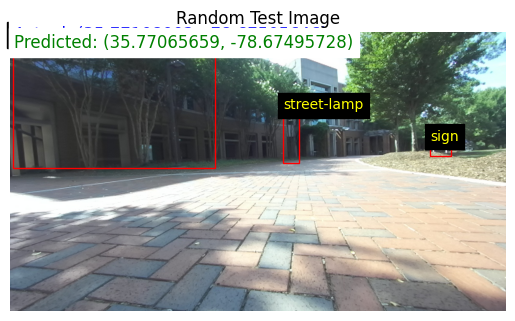

Actual: (35.77106094, -78.67404175)
Predicted: (35.77077484, -78.67489624)


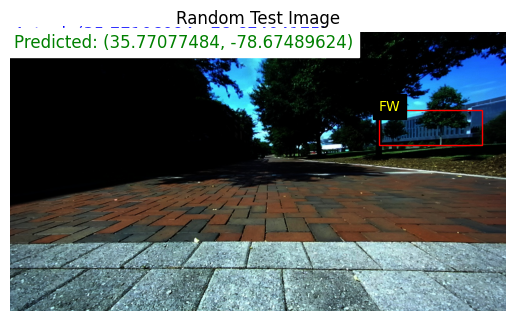

Actual: (35.77083588, -78.67492676)
Predicted: (35.77071762, -78.67492676)


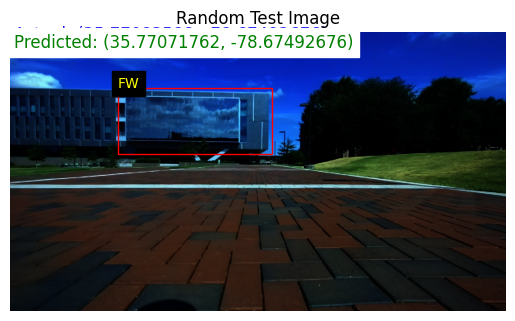

In [59]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_targets = []
image_paths = []

with torch.no_grad():
    for inputs, targets, paths in test_dataloader:
        outputs = model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)

all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set: {mse:.8f}')

import math
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.8f}')

# Function to visualize random test images with bounding boxes and geolocation labels
def visualize_random_predictions(test_dataset, all_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_geolocation = all_predictions[i].cpu().numpy()
        
        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display geolocations with clear labels (only latitude and longitude)
        plt.text(10, 20, f"Actual: ({geolocation[0]:.8f}, {geolocation[1]:.8f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted: ({predicted_geolocation[0]:.8f}, {predicted_geolocation[1]:.8f})", color='green', fontsize=12, backgroundcolor='white')
        print(f"Actual: ({geolocation[0]:.8f}, {geolocation[1]:.8f})")
        print(f"Predicted: ({predicted_geolocation[0]:.8f}, {predicted_geolocation[1]:.8f})")
        
        plt.title('Random Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the test set
visualize_random_predictions(test_dataset, all_predictions, num_images=10)
